In [2]:
import os

# Update the path to match the local system
base_dir = r'C:\Users\user\Desktop\Lung_Cancer_Streamlit\ctscan_images'  # Adjust the path accordingly

print("Contents of base directory:")
print(os.listdir(base_dir))

print("\nContents of train directory:")
print(os.listdir(f'{base_dir}\\train'))  # Using '\\' for folder structure

print("\nContents of test directory:")
print(os.listdir(f'{base_dir}\\test'))

Contents of base directory:
['test', 'train']

Contents of train directory:
['lung_cancer', 'normal']

Contents of test directory:
['lung_cancer', 'normal']


In [5]:
import os

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Directory with training cat/dog pictures
train_lung_cancer = os.path.join(train_dir, 'lung_cancer')
train_normal= os.path.join(train_dir, 'normal')

# Directory with validation cat/dog pictures
test_lung_cancer = os.path.join(test_dir, 'lung_cancer')
test_normal = os.path.join(test_dir, 'normal')

In [6]:
print('total training lung cancer images :', len(os.listdir(  train_lung_cancer ) ))
print('total training normal images :', len(os.listdir(  train_normal ) ))

print('total test lung caacer images :', len(os.listdir( train_lung_cancer ) ))
print('total test normal images :', len(os.listdir( train_normal ) ))

total training lung cancer images : 136
total training normal images : 151
total test lung caacer images : 136
total test normal images : 151


In [7]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

Now, display a batch of 8 cat and 8 dog pictures. You can re-run the cell to see a fresh batch each time:

In [8]:
train_lung_cancer_fnames = os.listdir( train_lung_cancer )
train_normal_fnames = os.listdir( train_normal )

print(train_lung_cancer_fnames[:10])
print(train_normal_fnames[:10])

['000002.png', '000003 (3).png', '000003 (4).png', '000009 (3).png', '000009 (4).png', '000010.png', '000015.png', '000016 (3).png', '000016 (4).png', '000017.png']
['003828_02_01_174.png', '004007_01_01_519.png', '004162_01_01_150.png', '10 (2) - Copy.png', '10 (2).png', '10 - Copy (2) - Copy.png', '10 - Copy (2).png', '10 - Copy (3).png', '10 - Copy - Copy.png', '10 - Copy.png']


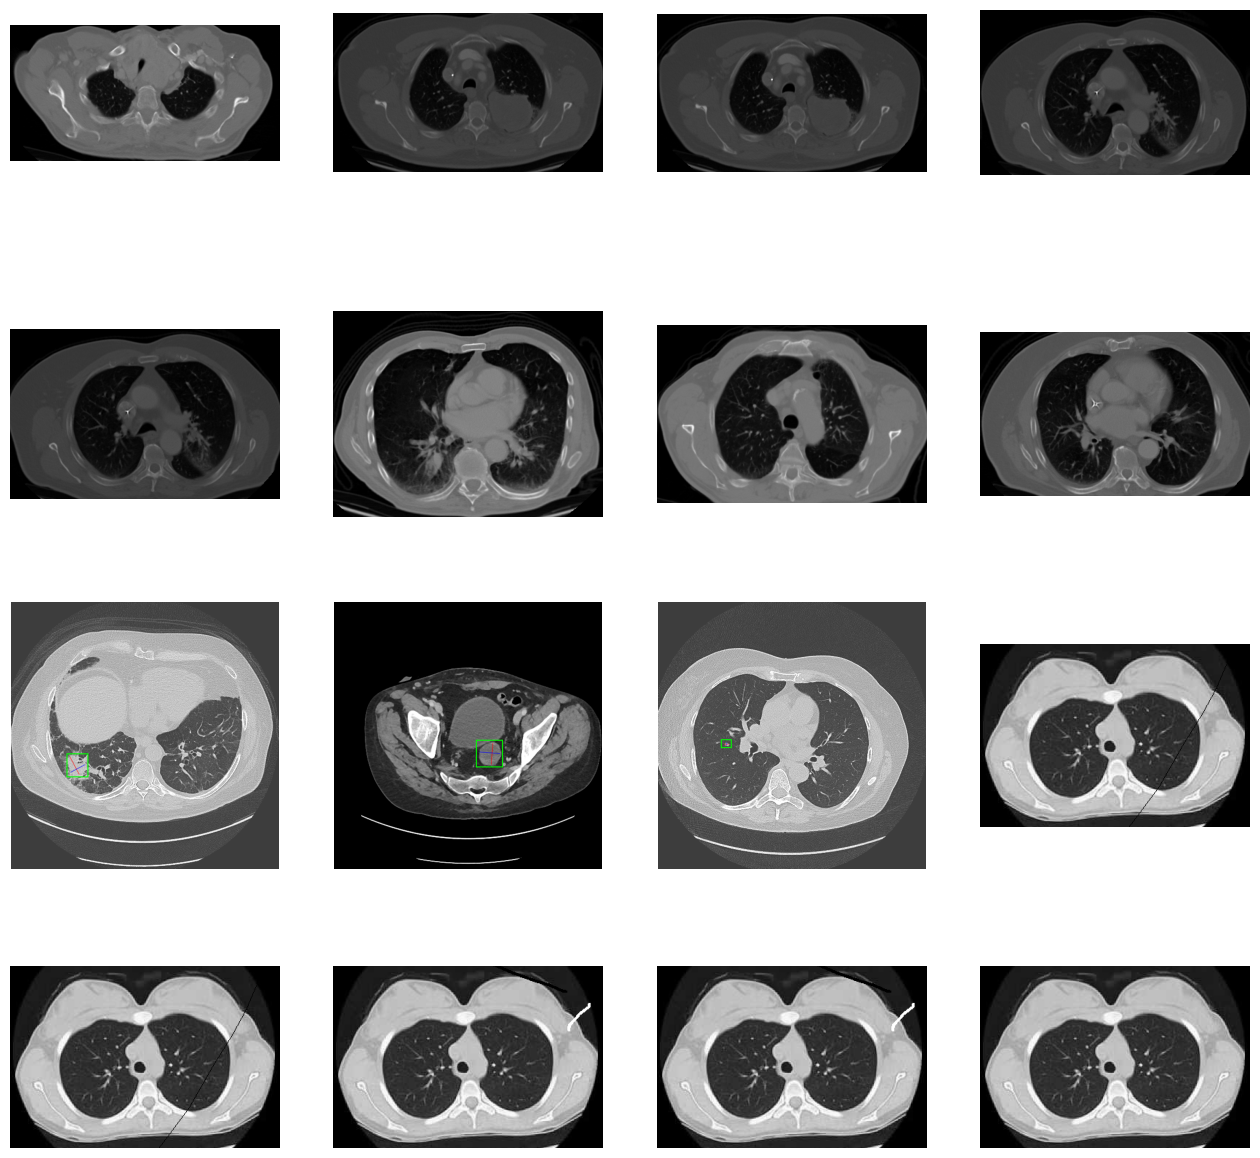

In [9]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join(train_lung_cancer, fname) 
                for fname in  train_lung_cancer_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_normal, fname) 
                for fname in train_normal_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

Building a Small Model from Scratch to get to ~72% Accuracy
To train a neural network to handle the images, you'll need them to be in a uniform size. You will choose 150x150 pixels for this, and you'll see the code that preprocesses the images to that shape shortly.

You can define the model by importing Tensorflow and using the Keras API. Here is the entire code first then the discussion comes after. This is very similar to the models you have built in Course 1.

In [27]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

You defined a `Sequential` layer as before, adding some convolutional layers first. Note the `input_shape` parameter this time. Here is where you put the `150x150` size and `3` for the color depth because you have colored images. You then add a couple of convolutional layers and flatten the final result to feed into the densely connected layers.

Note that because you are facing a two-class classification problem, i.e. a *binary classification problem*, you will end the network with a [*sigmoid* activation](https://wikipedia.org/wiki/Sigmoid_function). The output of the network will be a single scalar between `0` and `1`, encoding the probability that the current image is class `1` (as opposed to class `0`).

You can review the architecture of the network with the `model.summary()` method: 

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 26, 26, 64)      

Next, you'll configure the specifications for model training. You will train our model with the `binary_crossentropy` loss, because it's a binary classification problem and your final activation is a sigmoid. We will use the `rmsprop` optimizer with a learning rate of `0.001`. During training, you will want to monitor classification accuracy.

**NOTE**: In this case, using the [RMSprop optimization algorithm](https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) is preferable to [stochastic gradient descent](https://developers.google.com/machine-learning/glossary/#SGD) (SGD), because RMSprop automates learning-rate tuning for us. (Other optimizers, such as [Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam) and [Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad), also automatically adapt the learning rate during training, and would work equally well here.)

In [29]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

### Data Preprocessing

Next step is to set up the data generators that will read pictures in the source folders, convert them to `float32` tensors, and feed them (with their labels) to the model. You'll have one generator for the training images and one for the validation images. These generators will yield batches of images of size 150x150 and their labels (binary).

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network (i.e. It is uncommon to feed raw pixels into a ConvNet.) In this case, you will preprocess the images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).

In Keras, this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows you to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`.

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(224, 224))     
# --------------------
# Flow test images in batches of 20 using test_datagen generator
# --------------------
test_generator =  test_datagen.flow_from_directory(test_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (224, 224))

Found 287 images belonging to 2 classes.
Found 105 images belonging to 2 classes.


### Training
You will now train on all 2,000 images available, for 15 epochs, and monitor the accuracy as well on the 1,000 images in the validation set.

Do note the values per epoch.

You'll see 4 values per epoch -- Loss, Accuracy, Validation Loss and Validation Accuracy. 

The `loss` and `accuracy` are great indicators of progress in training. `loss` measures the current model prediction against the known labels, calculating the result. `accuracy`, on the other hand, is the portion of correct guesses. 

In [33]:
history = model.fit(
            train_generator,
            epochs=15,
            validation_data=test_generator,
            verbose=2
            )

Epoch 1/15
15/15 - 10s - loss: 3.3280 - accuracy: 0.5889 - val_loss: 0.3299 - val_accuracy: 0.9238 - 10s/epoch - 695ms/step
Epoch 2/15
15/15 - 6s - loss: 0.1761 - accuracy: 0.9512 - val_loss: 0.1665 - val_accuracy: 0.9238 - 6s/epoch - 421ms/step
Epoch 3/15
15/15 - 6s - loss: 0.1867 - accuracy: 0.9268 - val_loss: 0.2028 - val_accuracy: 0.9333 - 6s/epoch - 418ms/step
Epoch 4/15
15/15 - 6s - loss: 0.0171 - accuracy: 0.9965 - val_loss: 0.1297 - val_accuracy: 0.9524 - 6s/epoch - 424ms/step
Epoch 5/15
15/15 - 6s - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.1526 - val_accuracy: 0.9524 - 6s/epoch - 403ms/step
Epoch 6/15
15/15 - 6s - loss: 0.6649 - accuracy: 0.9233 - val_loss: 0.2111 - val_accuracy: 0.9238 - 6s/epoch - 426ms/step
Epoch 7/15
15/15 - 6s - loss: 0.0089 - accuracy: 1.0000 - val_loss: 0.1612 - val_accuracy: 0.9429 - 6s/epoch - 423ms/step
Epoch 8/15
15/15 - 6s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.1519 - val_accuracy: 0.9524 - 6s/epoch - 415ms/step
Epoch 9/15
15/15 - 6s 

In [34]:
from keras.models import load_model
model.save("lungcancer.h5")

In [46]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import tkinter as tk
from tkinter import filedialog
import os

# Load your trained model
model = load_model('lungcancer.h5')  # Replace with the correct path to your model file

# Function to upload image and make predictions
def upload_and_predict():
    # Open file dialog to select an image file
    root = tk.Tk()
    root.withdraw()  # Hide the root window
    file_path = filedialog.askopenfilename(title="Select an Image", filetypes=[("Image files", "*.jpg;*.jpeg;*.png")])

    if file_path:  # Ensure a file is selected
        # Load and preprocess the image (resize to match the model's expected input size)
        img = image.load_img(file_path, target_size=(224, 224))  # Adjust size if needed
        x = image.img_to_array(img)
        x /= 255  # Normalize image
        x = np.expand_dims(x, axis=0)  # Add batch dimension
        
        # Make prediction
        classes = model.predict(x)
        
        print(classes[0])
        
        # Check the prediction result
        if classes[0][0] > 0.5:
            print(f"{os.path.basename(file_path)} is a normal case")
        else:
            print(f"{os.path.basename(file_path)} is a lung cancer case")

# Call the function to upload and predict
upload_and_predict()


[1.]
6 - Copy (2) - Copy.png is a normal case


In [36]:
# Plot training results
import pandas as pd
model_loss= pd.DataFrame(history.history)
model_loss



,loss,accuracy,val_loss,val_accuracy
0,3.327976,0.588850,0.329876,0.923810
1,0.176068,0.951219,0.166494,0.923810
2,0.186669,0.926829,0.202833,0.933333
3,0.017132,0.996516,0.129707,0.952381
4,0.002473,1.000000,0.152589,0.952381
5,0.664869,0.923345,0.211084,0.923810
6,0.008856,1.000000,0.161247,0.942857
7,0.001658,1.000000,0.151895,0.952381
8,0.000372,1.000000,0.210659,0.942857
9,0.000136,1.000000,0.160379,0.961905


<Axes: >

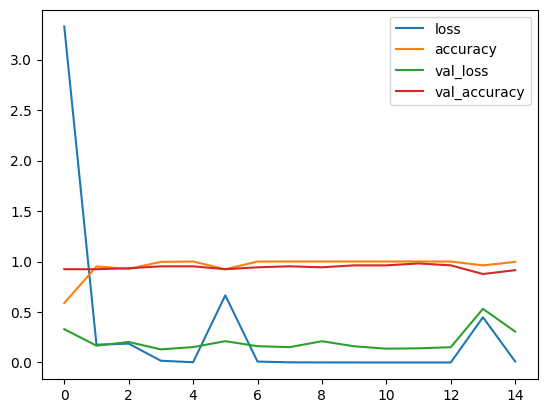

In [37]:
model_loss.plot()

In [38]:
import matplotlib.pyplot as plt

def plot_loss_acc(history):
  '''Plots the training and test loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and test accuracy')

  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and test loss')
  plt.legend()

  plt.show()

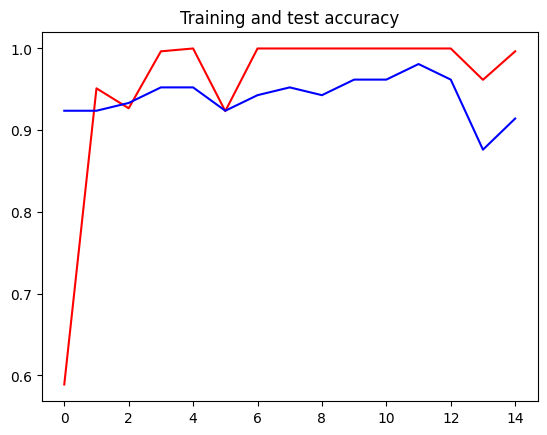

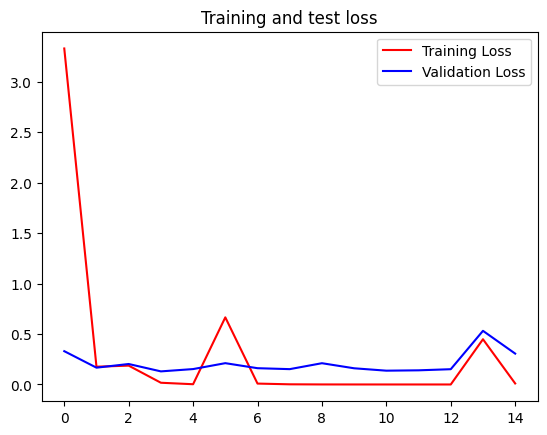

In [39]:
# Plot training results
plot_loss_acc(history)